<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0611202, r0633222, r0621101, r4, r5</span>. (fill in your student numbers!)

In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 0* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/b7a2a8743bd842ca9ac93ae91cbc8d9f) prior to the deadline on **Tuesday 18 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 1* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 0 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
import tensorflow as tf
import tensorflow_addons as tfa
if tfa.__version__=='0.12.1':
    !pip install --upgrade tensorflow-addons
    import tensorflow_addons as tfa
from tensorflow import keras
from keras import backend as K
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import os 
import multiprocessing
import wandb
# !pip install wandb -qqq
from wandb.keras import WandbCallback
import kerastuner as kt
import cv2
from ipywidgets import fixed, interact 
import ipywidgets
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, RandomBrightnessContrast, RandomCrop)

from data_utils import Dataset_Segmentation, Dataset_Classification

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

In [ ]:
# Loading the training data
train_df = pd.read_csv('data/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('data/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('data/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

# Show some examples
fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
for i, label in enumerate(labels):
    df = train_df.loc[train_df[label] == 1]
    axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
    axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
    axs[0, i].axis("off")
    axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
    axs[1, i].axis("off")
    
plt.show()

# The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
train_df.head(1)

In [ ]:
# Loading the test data
test_df = pd.read_csv('data/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('data/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [ ]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# Looking at the data

<div class="alert alert-block alert-success"><b>Taking a look at the data first:</b> <br>
Training usefull classification and segmentation models always starts by inspecting the data available. Within this section we perform such an evaluation on our training set. 
Thinks to consider are: 
<ol>
  <li>The distribution of classes within the data. In total 20 classes are considered, plus an additional background class for segmentation. These classes should be equally represented within the data, ideally each class would correpsond to 5% of all images in this particular case. This is important since models will be biased towards over-represented classes within the data.</li>
  <li>What labels are provided and are they accurate?</li>
  <li>Is there enough data, is data augmenetation necessary? </li>
</ol>
    
These questions will be answered within this section
</div>

## Visualizing the class distribution

<div class="alert alert-info">
<b>Class distribution</b> <br>
The figure below shows the distribution of classes within the training data. It becomes clear how around 25% of all images are labelled as containing a person. In fact this is not entirely true since we're dealing with a multi-label classification problem, meaning that an image is assigned a set of labels. However, the conclussion remains, the person class is over-represented within the data. We should keep this in mind when defining models. Likewise we also note that the classes sheep and cow are somewhat under represented within the data.
    
<b>Additional remarks</b> <br>
<ol>
  <li>Images contained within the training data have various different size. For training all of these are resized to a fixed size, default set to 224 width and height. We should however remain carefull when resizing data, in particular for our segmentation problems. Literature states that maintaining the aspect ratio is important for good segmentation. Therefore padding images to a fixed size might be beneficial for segmentation.</li>
  <li>Within our training data we've included a train versus validation split. By default we use 10% for validating.     </li>
</ol>
</div>

In [ ]:
dataset_config = {
    'train_fraction': 0.9,
    'input_shape': (224, 224),
    'augmentation': True, 
    'uniform_sample_probabilities': False
}
ds = Dataset_Classification(dataset_config)
ds.show_class_distribution()

<div class="alert alert-info">
<b>Comparing original and processed data</b> <br>
    Within the cell below you can visualize the data and look at the result after preprocessing. Uptill now preprocessing only consists out of resizing. However pretrained models always come with a preprocess function, rescaling the input from the 8 bit integer range into the 0 to 1 or -1 to 1 range. Such a function can be fed into our dataset class and will be called when preprocessing is done. In comment we give an example preprocess function,  uncommenting it will influence the preprocessed data.
</div>

In [ ]:
image_id = ipywidgets.IntText(min=0, max=ds.get_train_set_size(), value=0, label='image_id')
#ds.feed_preprocess_function(lambda x: x/255.0) 
option = ipywidgets.Dropdown(
    options=['train', 'test'],
    value='train',
    description='train or test:',
    disabled=False,
)
interact(ds.view_preprocessed_image,  image_id=image_id, option=option)

## Augmentation

<div class="alert alert-info">
<b>Data Augmentation</b> <br>
You might have already noticed that the original and preprocessed data can differ sometimes. This because data augmentation is enabled by default. Augmentation our data is necessary due to the limit amount of data and high probablity of overfitting on it. Augmentations are done using the albumentations module, each agmentation is defined by an action and a probablity. 
    
<b>Augmentations done</b> <br>
<ol>
  <li>Horizontal flip, probability 50%</li>
  <li>Random contrast: probability 25%</li>
  <li>Random brightness: probability 50%</li>
  <li>Random shift: probability 80% with a limit of 10% of the image width</li>
  <li>Random rotation: probability 80% with a limit of 15 degrees</li>
</ol>
    
    
The cell below shows each image from the training data and possible augmentations derived from it.
</div>

In [ ]:
image_id = ipywidgets.IntText(min=0, max=ds.get_train_set_size(), value=0, label='image_id')
interact(ds.view_possible_augmentations,  image_id=image_id)

# Looking at the labels for segmentation

<div class="alert alert-info">
<b>semantic segmentation labels</b> <br>
The assignemnt is centerred around semantic segmentation, the problem of segmenting all classes within an image. For this we need a label with the same size as the image, for which each pixel has the value of the corresponding class. Semantic segmentation is very different from instance segmentation, where all instaces of different classes are segmented seperatly. For this each pixel corresponding to a particular instance is given a different label. We've should make sure that these semantic labels of the data remain valid after applying augmentation.
    
Within the cells below you can visualize the original, preprocessed and semantic mask for the preprocessed image.
</div>

In [ ]:
dataset_config = {
    'train_fraction': 0.9,
    'input_shape': (224, 224),
    'augmentation': True, 
    'uniform_sample_probabilities':True
}
ds = Dataset_Segmentation(dataset_config)
#ds.feed_preprocess_function(lambda x: x/255.0) 

In [ ]:
image_id = ipywidgets.IntText(min=0, max=ds.get_train_set_size(), value=0, label='image_id')
option = ipywidgets.Dropdown(
    options=['train', 'test'],
    value='train',
    description='train or test:',
    disabled=False,
)
interact(ds.view_preprocessed_image,  image_id=image_id, option=option)

<div class="alert alert-info">
<b>Augmentation affects the segmentation labels</b> <br>
With the cell below we want to illustrate how the semantic labels remain valid after applying augmentatio. The augmentations influencing the semantic label are rotations, translation and rescalings.
</div>

In [ ]:
image_id = ipywidgets.IntText(min=0, max=ds.get_train_set_size(), value=0, label='image_id')
interact(ds.view_possible_augmentations,  image_id=image_id)

# Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

<div class="alert alert-block alert-success"><b>Multi label classification:</b> <br>
    The first section will focus on the most succesfull classification models considered. We've focussed on models provided within the keras applications. The models available have proven their capabilities and are well documented. Additionally pretrained weights from imagenet are availabel for all these models.
    
Our base classification model class includes a high number of methods, therefore we import it instead of defining it over here. This base class takes care of most things, most importantly the head model. This are the final (dense) layers added on top of the base model. The strategy used is to inherit from this base class and define a specific base model. 
</div>

In [1]:
from model_utils import ClassifactionModel
import keras

<div class="alert alert-info">
<b>Xception</b> <br>
Our first model used will be Xception, we load it from keras and do not include the top layers. Optionally we could load the pretrained weights. this is done when finetuning the model. Within the cell below we define the model and set the configurations. We will a initialize a model obtained through finetuning on the imagenet weights, this model head no dense layers within the head model. We just added one final layer corresponding to the number of classes.  
</div

In [2]:
class XceptionModel(ClassifactionModel): 
    def __init__(self, config):
        # setup model name for wandb
        self.project_name = 'Xception'
        self.heatmap_layer_name='block14_sepconv2_act'
        # define the base model
        self.base_model = keras.applications.xception.Xception(weights="imagenet",
                                                               include_top=False)
        # super takes care of the rest
        super().__init__(config)
        
        # feed preprocessor function 
        self.dataset.feed_preprocess_function(keras.applications.xception.preprocess_input)
        
config_xception = {
    'name': 'XceptionModel',
    'logging_wandb': False,  #nice tool for tracking a run. tensorboad-like
    'weights': "imagenet", # 'imagenet', #None, 
    'nbr_classes': 20,
    'input_shape': (224, 224, 3),
    'train_base_model': True, # whether to train the head and or base model
    'train_head_model': True, 
    'train_parameters': {
        'optimizer': 'ADAM',
        'epochs': 5,
        'batch_size': 64,
        'learning_rate': 0.00001, 
        'steps_per_epoch': 2000
    },
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': False
    },
    'head_model': {
        'head_model_units': [], 
        'add_dropout':      [],
        'activation': 'relu'
    }
}
import tensorflow as tf
# # GPU 
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)
        
#CPU
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

<div class="alert alert-info">
<b>Inference</b> <br>
We will not train the model again but just us it for inference, the cpu is used to avoid problems with the gpu. We show predictions made on the test by outputting its most confident prediction, along with a hint on where the model is basing this prediction on. For this we show the activations of a predefined convolutonal layer from within the model. Such a visualization can help in understanding why the model is behaving in a certain way.

<b>Interesting image to look at:</b> <br>
<ol>
  <li>Image_id=1: The image shows multiple classes present within the training data such as potted plant, tables and chairs. Finally it predicts the chair as most confident predection. By looking at the activation is becomes clear that the model is indeed focussing on the part of the image where the chair is.</li>
  <li>Image_id=4, 6, 35: Same as previously. Within these images the activation also explains why a particular prediction is made when multiple classes are present.</li>
  <li>Image_id=12: It's clear how the model is basing its prediction on the cat its face.</li>
  <li>Image_id=25: The predicted boat is accurate, however the focus of the model for making this prediction is questionable. The activations do not focus on the boat but on the water. This is a commonly encoutered, the model has learned to predict boat when it sees water. Meaning that this prediction is in fact based on the context of a boat, mostly found within water. </li>
  <li>Image_id=6: This prediction supports the argument made above. The prediction is still accurate, however much less confident.</li>
  <li>Image_id=38: Our model is still confusing cats and dogs..</li>
</ol>
</div

In [3]:
Xception = XceptionModel(config_xception)
Xception.prepare_for_inference('weights/Xception_finetuned.h5', force_cpu=True)

Found 749 train images
- 674 used for training, 75 used for validating
Found 750 test images
Including augmentation when training data is generated


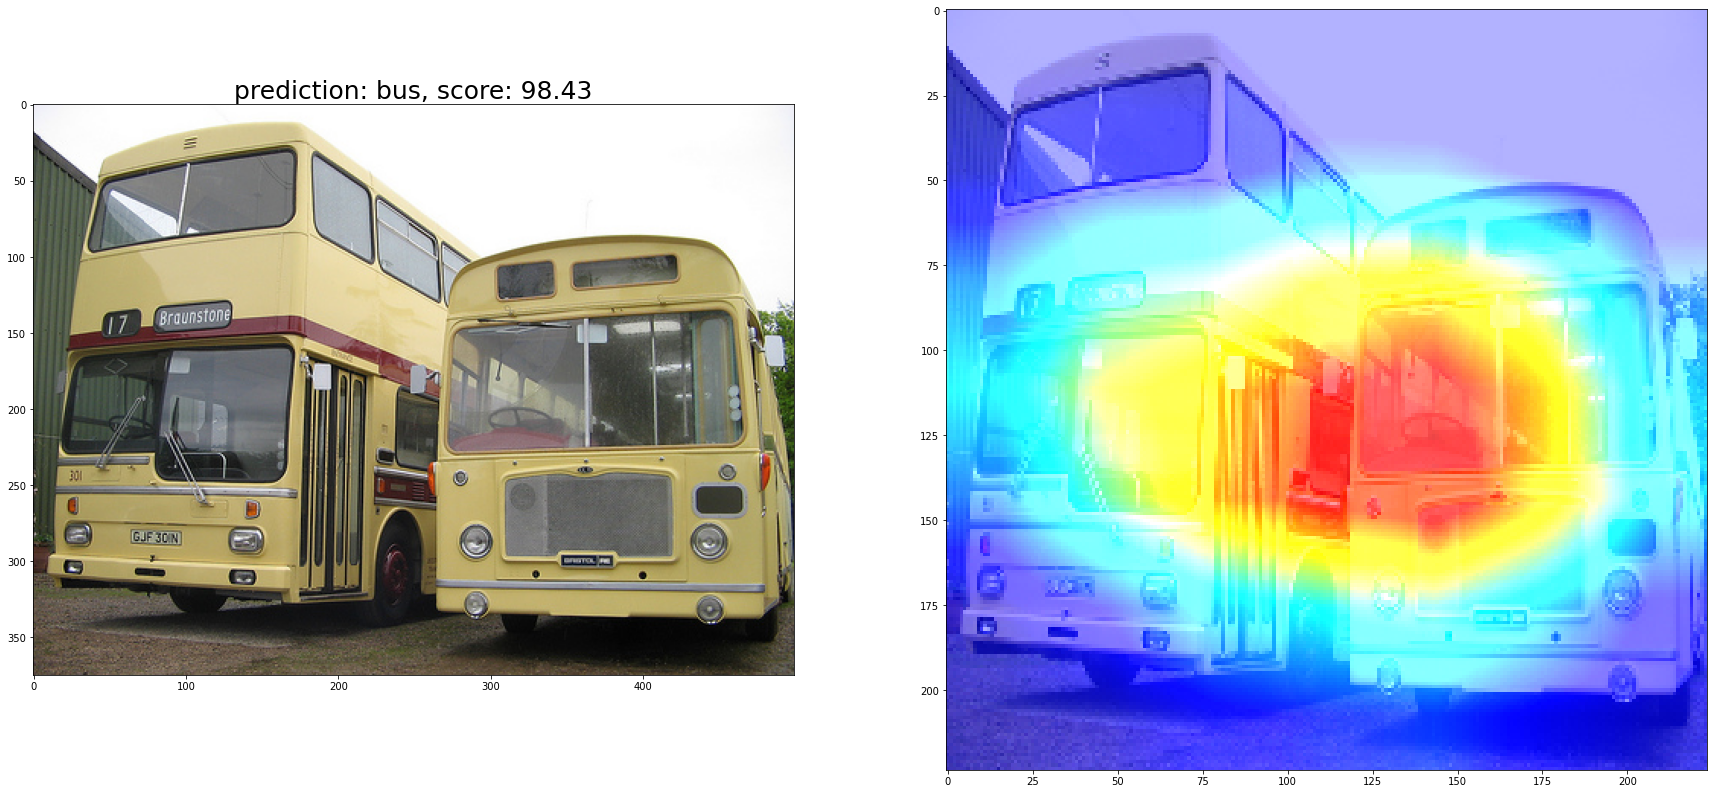

In [71]:
image_id=39
with tf.device('/cpu:0'):
    Xception.show_heatmap_prediction(image_id)

<div class="alert alert-info">
<b>ResNet50</b> <br>
We will do the same as previously done for Xception. But now with a bigger base model which is resnet50. This model is commonly used as feature extractor in popular models. 
</div

In [74]:
class ResNet50Model(ClassifactionModel): 
    def __init__(self, config):
        # setup model name for wandb
        self.project_name = 'resnet50'
        self.heatmap_layer_name='conv5_block3_out'
        # define the base model
        self.base_model = keras.applications.ResNet50V2(weights="imagenet",
                                                               include_top=False)
        # super takes care of the rest
        super().__init__(config)
        
        # feed preprocessor function 
        self.dataset.feed_preprocess_function(keras.applications.resnet_v2.preprocess_input)
config = {
    'name': 'ResNet50',
    'logging_wandb': False,  #nice tool for tracking a run. make and account on wandb.ai and I will add you to this project
    'weights': "imagenet", # 'imagenet', #None, 
    'nbr_classes': 20,
    'input_shape': (224, 224, 3),
    'train_base_model': False, # whether to train the head and or base model
    'train_head_model': True, 
    'train_parameters': {
        'optimizer': 'ADAM',
        'epochs': 3,
        'batch_size': 64,
        'learning_rate': 0.000001, 
        'steps_per_epoch': 2000
    },
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': False
    },
    'head_model': {
        'head_model_units': [], 
        'add_dropout':      [],
        'activation': 'relu'
    }
}

In [75]:
resnet50=ResNet50Model(config)
resnet50.prepare_for_inference('weights/resnet50.h5')

Found 749 train images
- 674 used for training, 75 used for validating
Found 750 test images
Including augmentation when training data is generated
Physical devices cannot be modified after being initialized


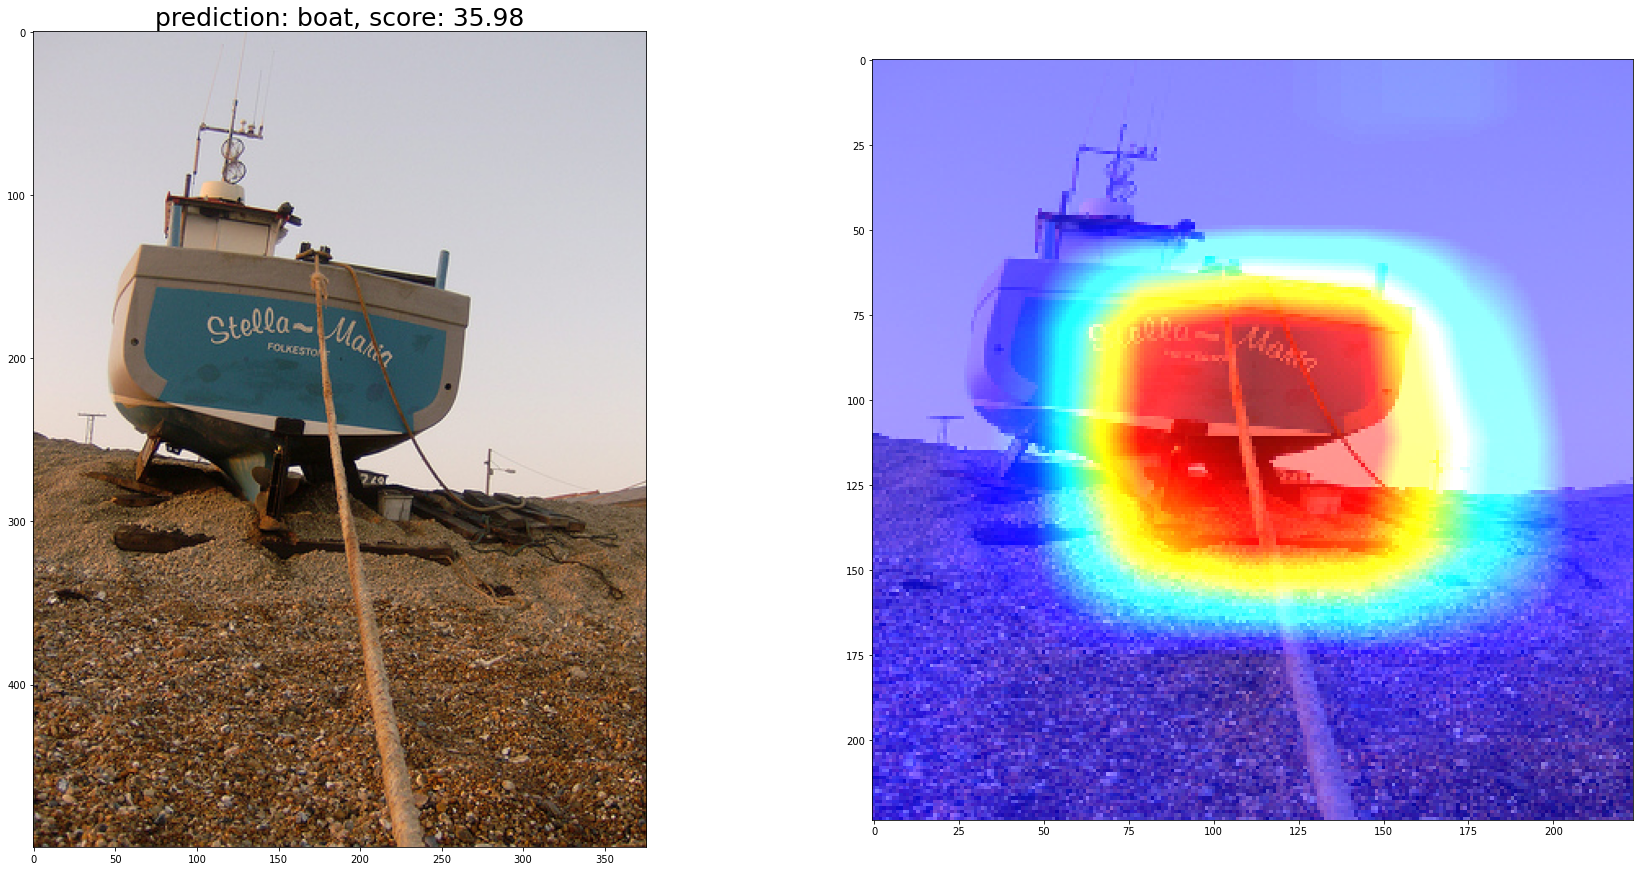

In [81]:
image_id=6
with tf.device('/cpu:0'):
    resnet50.show_heatmap_prediction(image_id)

### Hypermodel tuning

In [ ]:
class ResNet50HyperModel(kt.HyperModel):
    def __init__(self, config):
        self.config = config

    def build(self, hp):
#         wandb.init(config=hp.values, **self.config['wandb'])
        # build base and head models
        resnet50 = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=self.config['input_shape'])
        resnet50.trainable = False
        model = tf.keras.Sequential()
        model.add(resnet50)
        model.add(tf.keras.layers.GlobalAveragePooling2D())
        model.add(tf.keras.layers.BatchNormalization())
        # add head model hidden layers set by hyperparams
        model.add(tf.keras.layers.Dense(
                units=hp.Int('head_units_0',min_value=256,max_value=1024,step=64),
                activation='relu',
                kernel_regularizer='l2'))
        model.add(tf.keras.layers.Dense(
                units=hp.Int('head_units_1',min_value=32,max_value=256,step=32),
                activation='relu',
                kernel_regularizer='l2'))
        # add head model output layer with sigmoid activation
        model.add(tf.keras.layers.Dense(
                units=self.config['nbr_classes'],
                activation='sigmoid'))
        self.model = model
        # get optimizer from hyperparameters
        lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log', default=1e-3)
        optimizer = tf.keras.optimizers.SGD(lr)
        # track some metrics while training
        metrics = [
                    tf.keras.metrics.BinaryAccuracy()
                  , tfa.metrics.FBetaScore(num_classes=20, beta=2., average='weighted')
                  ]
#         loss = tfa.losses.SigmoidFocalCrossEntropy(reduction='auto')
        loss = tf.keras.losses.KLDivergence()
        self.model.compile(optimizer=optimizer, metrics=metrics, loss=loss)
        return self.model

In [ ]:
class ResNetHyperClassModel(RandomClassificationModel):
    def __init__(self, config):
        self.config = config
        self.hypermodel = ResNet50HyperModel(config['hypermodel'])
        self.tuner = kt.Hyperband(
            self.hypermodel,
            objective=kt.Objective("val_fbeta_score", direction="max"),
            max_epochs=20,
            directory='hypertuners',
            project_name=config['hypermodel']['wandb']['project']
        )
        
    def load_best_model_from_disk(self):
        self.best_model = self.tuner.get_best_models(num_models=1)[0]

    def fit(self, X, y=None):
        if isinstance(X, Dataset_Classification):
            print("using custom dataset")
            self.tuner.search(
                x = X.train_generator(self.config['train_parameters']['batch_size']), 
                validation_data = X.validation_generator(self.config['train_parameters']['batch_size']),
                #callbacks=[WandbCallback(save_model=False)],
                **self.config['tuner_search']
            )
        else:
            self.tuner.search(X, y, validation_split=.2, **self.config['tuner_search'])
        self.best_model = self.tuner.get_best_models(num_models=1)[0]
            
    def predict(self, X):
        # let best model predict
        if isinstance(X, Dataset_Classification):
            pred = self.best_model.predict(x=X.test_generator(50), use_multiprocessing=True)
        else:
            pred = self.best_model.predict(X)
        # threshold output
        pred[pred >= .5] = 1
        pred[pred <  .5] = 0
        return pred

In [ ]:
config = {
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': False
    },
    'train_parameters': {
        'batch_size': 64
    },
    'hypermodel': {
        'input_shape': (224, 224, 3),
        'nbr_classes': 20,
        'wandb': {
            'project': 'resnethyper_new_focal',
            'entity': 'cv-task-2',
            'notes': 'ResNet50 being hyperparameter tuned with keras hyperband',
            'tags': ['resnet50', 'hyperband']
        }
    },
    'tuner_search': {
        'steps_per_epoch': 256,
        'validation_steps': 32
    }
}
hyper_resnet = ResNetHyperClassModel(config)
hyper_dataset = Dataset_Classification(hyper_resnet.config['dataset'])

In [ ]:
# perform hyperparameter tuning on model, automatically writes all runs to disk
hyper_resnet.fit(hyper_dataset)

In [ ]:
# write prediction to dataframe
test_df.iloc[:,0:20] = clf_pred.astype('uint8')

## Best model so far

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
efficientnet = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=inputs
)
efficientnet.trainable = False
model = tf.keras.Sequential()
model.add(efficientnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(20, activation='sigmoid'))#, kernel_regularizer='l2'))
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(reduction='auto'),
              optimizer='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(), tfa.metrics.FBetaScore(num_classes=20, beta=2., average='weighted')])

In [ ]:
model.summary()

In [ ]:
ds = Dataset_Classification(config['dataset'])
history=model.fit(x=ds.train_generator(64), validation_data=ds.validation_generator(32), epochs=4, steps_per_epoch=128, validation_steps=32)

In [ ]:
model.save('models/efficientnetb0_class')

In [ ]:
#run this cell to load model from disk
model = keras.models.load_model('models/efficientnetb0_class')

In [ ]:
efficientnet.trainable=True
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(reduction='auto'),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tfa.metrics.FBetaScore(num_classes=20, beta=2., average='weighted')])

In [ ]:
history=model.fit(x=ds.train_generator(64), validation_data=ds.validation_generator(32), epochs=20, steps_per_epoch=128, validation_steps=32)

In [ ]:
clf_pred = model.predict(x=ds.test_generator(50), use_multiprocessing=True)
clf_pred[clf_pred >= .5] = 1
clf_pred[clf_pred <  .5] = 0
test_df.iloc[:,0:20] = clf_pred.astype('int')

In [ ]:
def show_test_classes(image_id):
    fig, ax = plt.subplots()
    real_image = np.load('data/test/img/test_{}.npy'.format(image_id) )
    plt.suptitle('Classes: {}'.format(test_df.iloc[:,0:20].columns[clf_pred[image_id]==1.].tolist()))
    ax.imshow(real_image)
    fig.show()
image_id = ipywidgets.IntText(min=0, max=749, value=0, label='image_id')
interact(show_test_classes,  image_id=image_id)

# custom model

In [ ]:
class CustomModel(ResNetClassifactionModel): 
    def __init__(self, config):
        self.config = config 
        self.config_head = config['head_model']
        self.project_name = 'custom'
        
        # initialize dataset
        self.dataset = Dataset_Classification(config['dataset'])
        
        # feed preprocessor to dataset
        print('Feeding resnet50 preprocess function to dataset class')
        self.dataset.feed_preprocess_function(lambda x: x/255.0)
    
    def build(self):
        print('simple cnn')
        model = keras.models.Sequential([
            keras.layers.Conv2D(64,7, activation='relu', padding="same", 
                                input_shape=self.config['input_shape']), 
            keras.layers.MaxPooling2D(2), 
            keras.layers.Conv2D(128,3,activation='relu', padding='same'),
            keras.layers.Conv2D(128,3,activation='relu', padding='same'),
            keras.layers.MaxPooling2D(2),
            keras.layers.Conv2D(256,3,activation='relu', padding='same'),
            keras.layers.Conv2D(256,3,activation='relu', padding='same'),
            keras.layers.MaxPooling2D(2), 

            keras.layers.Flatten(), 
            keras.layers.Dense(128, activation='relu'), 
            keras.layers.Dropout(0.5), 
            keras.layers.Dense(64, activation='relu'), 
            keras.layers.Dropout(0.5), 
            keras.layers.Dense(self.config['nbr_classes'], activation='softmax')
            ])
        self.model=model

In [ ]:
config = {
    'name': 'resnet50 KL divergence',
    'logging_wandb': False,  #nice tool for tracking a run. make and account on wandb.ai and I will add you to this project
    'weights': 'imagenet', #None, 
    'nbr_classes': 20,
    'input_shape': (224, 224, 3),
    'train_base_model': True, # whether to train the head and or base model
    'train_head_model': True, 
    'train_parameters': {
        'epochs': 20,
        'batch_size': 64,
        'learning_rate': 0.01, 
        'steps_per_epoch': 100
    },
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        "uniform_sample_probabilities": False
    },
    'head_model': {
        'head_model_units': [1024, 1024], 
        'add_dropout':      [True, True],
        'activation': 'relu'
    }
}

In [ ]:
Custom = CustomModel(config)

In [ ]:
name_run=''
notes=''
tags = ['custom']
Custom.train(name_run, notes, tags)

## VGG19

In [ ]:
class VGG19ClassifactionModel(ResNetClassifactionModel): 
    def __init__(self, config): 
        self.config = config 
        self.config_head = config['head_model']
        
        self.project_name = 'VGG19'
        
        # initialize dataset
        self.dataset = Dataset_Classification(config['dataset'])
        
        # feed preprocessor to dataset
        print('Feeding vgg19 preprocess function to dataset class')
        self.dataset.feed_preprocess_function(tf.keras.applications.vgg19.preprocess_input)
        
        # check if some configurations make sense 
        assert len(self.config_head['head_model_units']) == len(self.config_head['add_dropout']), 'head_models_units and add_dropout list should have same size'
        
    def build(self): 
        """
            Builds the model 
        """
        # define a resnet50 base model
        VGG19 = tf.keras.applications.VGG19(
                    include_top=False,
                    weights=self.config['weights'],
                    input_shape=self.config['input_shape'],
                        )
    
        self.base_model = VGG19
        
        # define a head model
        head_model=VGG19.output
        #head_model=tf.keras.layers.AveragePooling2D(pool_size=(7,7))(head_model)
        head_model=tf.keras.layers.Flatten()(head_model)
        
        for (nbr_units, dropout) in zip(self.config_head['head_model_units'], self.config_head['add_dropout']): 
            head_model=tf.keras.layers.Dense(nbr_units, activation=self.config_head['activation'])(head_model)
            if dropout:
                head_model=tf.keras.layers.Dropout(0.2)(head_model)
        
        head_model=tf.keras.layers.Dense(self.config['nbr_classes'], activation='linear')(head_model)
        
        self.head_model = head_model
                
            
        # combine both models 
        self.model = tf.keras.Model(self.base_model.input, self.head_model)

In [ ]:
config = {
    'name': 'vgg19',
    'logging_wandb': False, 
    'weights': None, 
    'nbr_classes': 20,
    'input_shape': (224, 224, 3),
    'train_base_model': True, # whether to train the head and or base model
    'train_head_model': True, 
    'train_parameters': {
        'epochs': 10,
        'batch_size': 32,
        'learning_rate': 0.001, 
        'steps_per_epoch': 100
    },
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': False
    },
    'head_model': {
        'head_model_units': [2048], 
        'add_dropout':      [False],
        'activation': 'linear'
    }
}
#64, 128, 256, 512, 1024, 2048, 4096

In [ ]:
vgg_model=VGG19ClassifactionModel(config)
# vgg_model.build()
# vgg_model.model.summary()

In [ ]:
name_run='vgg19_'
notes='First try for finetuning vgg19 on pretrained imagenet weights. Data augmentation turned on. '
tags = ['resnet50', 'head = [2048]', 'head = [False]', 'Augmentation applied']
vgg_model.train(name_run, notes, tags)


In [ ]:
dataset_config = {
    'train_fraction': 0.9,
    'input_shape': (224, 224),
    'augmentation': False,
    'uniform_sample_probabilities': False
}
ds = Dataset_Segmentation(dataset_config)
# resnet50 preprocessor 
ds.feed_preprocess_function(lambda x: x/255.0)

i = 0
for X,y in ds.train_generator(0): 
    if i > 1: 
        break 
    i+=1 
print(X.shape)
print(y.shape)
fig, axes = plt.subplots(1,2)
axes[0].imshow(X[0])
axes[1].imshow(y[0])

In [ ]:
print(y[0].shape)
print(np.unique(y[0]))
idx = np.where(y[0] == 2)
zrs = np.zeros(y[0].shape)
zrs[idx]=1
plt.imshow(zrs)

In [ ]:
gen = ds.test_generator(1)
im = next(gen)

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
model=tf.keras.applications.ResNet50V2()

# predict 
preds = model.predict(gen)
#preds = model.predict(im_pr)
tf.keras.applications.imagenet_utils.decode_predictions(
    preds, top=5
)


# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

In [ ]:
class RandomSegmentationModel:
    """
    Random segmentation model: 
        - generates random label maps for the inputs based on the class distributions observed during training
        - every pixel in an input can only have one label
    """
    def fit(self, X, Y):
        """
        Adjusts the class ratio variable to the one observed in Y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        Y: list of arrays - n x (height x width)

        Returns
        -------
        self
        """
        self.distribution = np.mean([[np.sum(Y_ == i) / Y_.size for i in range(len(labels) + 1)] for Y_ in Y], axis=0)
        print("Setting class distribution to:\nbackground: {}\n{}".format(self.distribution[0], "\n".join(f"{label}: {p}" for label, p in zip(labels, self.distribution[1:]))))
        return self
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
             
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        np.random.seed(0)
        return [np.random.choice(np.arange(len(labels) + 1), size=X_.shape[:2], p=self.distribution) for X_ in X]
    
    def __call__(self, X):
        return self.predict(X)
    
model = RandomSegmentationModel()
model.fit(train_df["img"], train_df["seg"])
test_df.loc[:, "seg"] = model.predict(test_df["img"])
test_df.head(1)

In [ ]:
class UnetSegmentationMode(ResNetClassifactionModel): 
    def __init__(self, config): 
        self.config=config
        self.config_head = config['head_model']
        self.output_channels=self.config['nbr_classes'] + 1 # plus one since background is a class
        
        # initialize dataset
        self.dataset = Dataset_Segmentation(config['dataset'])
        
        # feed preprocessor to dataset
        print('Feeding vgg19 preprocess function to dataset class')
        self.dataset.feed_preprocess_function(tf.keras.applications.vgg19.preprocess_input)
        
        self.project_name = 'Unet'
        
        
    ## 
    def upsample(self, filters, size, apply_dropout=False):
        initializer = tf.random_normal_initializer(0., 0.02)

        result = tf.keras.Sequential()
        result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

        result.add(tf.keras.layers.BatchNormalization())

        if apply_dropout:
            result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

        return result
    
    def compile_model(self): 
        # optimizer
        optimizer = tf.keras.optimizers.Adam(
                                learning_rate=self.config['train_parameters']['learning_rate'],
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name="Adam",
                            )

        metrics = ['acc', 
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top 3 categorical acccuracy'), 
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top 5 categorical acccuracy')
                  ]


        loss=loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
        
    def build(self):
        ## base model
        base_model = tf.keras.applications.MobileNetV2(input_shape=self.config['input_shape'], include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

        down_stack.trainable = False # hard code it to be not trainable
        
        self.base_model = down_stack
        ## head model
        
        up_stack = [
            self.upsample(512, 3, self.config_head['add_dropout']),  # 4x4 -> 8x8
            self.upsample(256, 3, self.config_head['add_dropout']),  # 8x8 -> 16x16
            self.upsample(128, 3, self.config_head['add_dropout']),  # 16x16 -> 32x32
            self.upsample(64, 3, self.config_head['add_dropout']),   # 32x32 -> 64x64
        ]
        
        inputs = tf.keras.layers.Input(shape=self.config['input_shape'])

        # Downsampling through the model
        skips = down_stack(inputs)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            concat = tf.keras.layers.Concatenate()
            x = concat([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            self.output_channels, 3, strides=2,
            padding='same')  #64x64 -> 128x128

        x = last(x)

        self.model = tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
Unet_config = {
    'name': 'Unet',
    'logging_wandb': True, 
    'nbr_classes': 20,
    'train_base_model': False, # whether to train the head and or base model
    'train_head_model': True, # not defined here
    'input_shape': (224, 224, 3),
    'train_parameters': {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 0.001, 
        'steps_per_epoch': 1000
    },
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': True
    },
    'head_model': {
        'add_dropout': True,
    }
}

In [ ]:
Unet = UnetSegmentationMode(Unet_config)

In [ ]:
name_run='Unet 1'
notes='Changed configurations, higher batch size, more steps per epoch'
tags = ['unet', 'Augmentation applied', 'dropout added']
Unet.train(name_run, notes, tags)

In [ ]:
pred_seg = np.argmax(Unet.model.predict(x=Unet.dataset.test_generator(50)), axis=3).astype('uint8')
test_df["seg"] = [cv2.resize(pred_seg[i], test_df["seg"][i].shape) for i in range(test_df.shape[0])]

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [ ]:
generate_submission(test_df)

# 4. Adversarial attacks
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

## Task definition (we should come up with a better task definition)!!!!
Our goal is to fool the network so that a well classified image gets classified with the wrong label. (No targeted attacks)

## Methods
There are probably two methods that will work here
1. Fast Gradient Sign Method (FGSM)
2. Projected Gradient Decent

## Setup
Use best model for classification

In [ ]:
config = {
    'dataset': {
        'train_fraction': 0.9,
        'input_shape': (224, 224),
        'augmentation': True, # whether to augment images or not
        'uniform_sample_probabilities': False
    },
    'train_parameters': {
        'batch_size': 64
    },
    'hypermodel': {
        'input_shape': (224, 224, 3),
        'nbr_classes': 20,
        'wandb': {
            'project': 'resnethyper_new_focal',
            'entity': 'cv-task-2',
            'notes': 'ResNet50 being hyperparameter tuned with keras hyperband',
            'tags': ['resnet50', 'hyperband']
        }
    },
    'tuner_search': {
        'steps_per_epoch': 256,
        'validation_steps': 32
    }
}

In [ ]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
efficientnet = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_tensor=inputs
)
efficientnet.trainable = False
model = tf.keras.Sequential()
model.add(efficientnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'))
model.add(tf.keras.layers.Dense(20, activation='sigmoid'))#, kernel_regularizer='l2'))
model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(reduction='auto'),
              optimizer='adam',
              metrics=[tf.keras.metrics.BinaryAccuracy(), tfa.metrics.FBetaScore(num_classes=20, beta=2., average='weighted')])

In [ ]:
model.summary()

In [ ]:
ds = Dataset_Classification(config['dataset'])
model = keras.models.load_model('models/efficientnetb0_class')

### FGSM implementation

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = image[None, ...]
  return image

def get_labels_prob(image_probs, label_names):
    clf_pred = np.array(np.copy(image_probs))
    clf_pred[image_probs >= .5] = 1
    clf_pred[image_probs <  .5] = 0
    return label_names[np.where(clf_pred > 0.9)[1]],  image_probs[image_probs >= .5]

def get_top_n_labels(image_probs, label_names, n):
    clf_pred = np.array(np.copy(image_probs))
    sorted_index = np.argsort(clf_pred)
    return clf_pred[0][sorted_index[0][-n:]], label_names[sorted_index[0][-n:]]

def get_multiple_hot_encoding(image_probs):
    clf_pred = np.array(np.copy(image_probs))
    clf_pred[image_probs >= .5] = 1
    clf_pred[image_probs <  .5] = 0
    return clf_pred

In [ ]:
test_images = ds.test_generator(1)
image = next(test_images)
image = image.reshape(224,224,3)
image = preprocess(image)
image_probs = model.predict(image)

In [ ]:
x,y = get_labels_prob(image_probs, ds.label_names)
plt.imshow(tf.reshape(image,(224,224,3))/255)
title_string = [str(i) + " " + "{:.2f}%".format(j*100) for i,j in zip(x,y)]
_ = plt.title(" ".join(title_string))


In [ ]:
loss_object = tfa.losses.SigmoidFocalCrossEntropy(reduction='auto')

def create_adversarial_pattern(input_image, input_labels): 
  
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image) # this function only works on uints images
    loss = loss_object(input_labels, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
input_labels = tf.convert_to_tensor(get_multiple_hot_encoding(image_probs))
perturbations = create_adversarial_pattern(image, input_labels)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]
_ = plt.title("perturbations")

In [ ]:
def display_images(image, description):
    plt.figure()
    image_probs = model.predict(image)
    x,y = get_top_n_labels(image_probs, ds.label_names, 3)
    title_string = [str(i) + " " + "{:.2f}%".format(j*100) for j,i in zip(x,y)]
    plt.title(" ".join(title_string))
    plt.imshow(tf.reshape(image, (224,224,3))/255)

In [ ]:
epsilons = [0, 0.1, 1, 5, 10, 20]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  display_images(adv_x, descriptions[i])

### DEMO with FGSM (run previous cells)

In [ ]:
ds = Dataset_Classification(config['dataset'])
model = keras.models.load_model('models/efficientnetb0_class')

In [ ]:
def create_and_show_adverserial_image(index, epsilon, n_pred):
    test_images = ds.test_generator(1)
    image = next(test_images)
    for i in range(index):
        image = next(test_images)
    image = image.reshape(224,224,3)
    image = preprocess(image)
    image_probs = model.predict(image)
    input_labels = tf.convert_to_tensor(get_multiple_hot_encoding(image_probs))
    perturbations = create_adversarial_pattern(image, input_labels)
    adv_x = image + epsilon*perturbations
    display_attack(image, perturbations, adv_x, epsilon)

def display_attack(image, perturbation, adv_x, epsilon):
    x1,y1 = get_top_n_labels(model.predict(image), ds.label_names, 3)
    title_string_im = [str(i) + " " + "{:.2f}%".format(j*100) for j,i in zip(x1,y1)]
    x2,y2 = get_top_n_labels(model.predict(adv_x), ds.label_names, 3)
    title_string_adv = [str(i) + " " + "{:.2f}%".format(j*100) for j,i in zip(x2,y2)]
    f, axarr = plt.subplots(1,3, figsize=(21,21))        
    axarr[0].imshow(tf.reshape(image, (224,224,3))/255)
    axarr[0].set_title(" ".join(title_string_im))
    axarr[1].imshow(perturbation[0] * 0.5 + 0.5)
    axarr[1].set_title("perturbation*" + str(epsilon))
    axarr[2].imshow(tf.reshape(adv_x, (224,224,3))/255)
    axarr[2].set_title(" ".join(title_string_adv))


In [ ]:
index = ipywidgets.IntText(min=0, max=ds.get_test_set_size(), value=0, label='image_id')
p_multiplier = ipywidgets.FloatText(min=0, max=100, value=5, label='perturbation multiplier')
top_n = ipywidgets.IntText(min=0, max=5, value=3, label='top_n_labels')
interact(create_and_show_adverserial_image, index=index, epsilon=p_multiplier, n_pred=top_n)

# Other methods
Here we will try to make targeted attacks with pgd
targeted attacks

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.